In [115]:
import numpy as np
import pandas as pd
from skopt import gp_minimize, gbrt_minimize 
from skopt.plots import plot_convergence, plot_objective
from rl4greencrab.envs.green_crab_monthly_env import greenCrabMonthEnv
from rl4greencrab.envs.green_crab_monthly_env_norm import greenCrabMonthEnvNormalized
from rl4greencrab.envs.green_crab_movingAvg import greenCrabMonthNormalizedMoving
from rl4greencrab import evaluate_agent, multiConstAction, simulator, environment_simulation, plot_selected_sizes, agent_action_plot
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from stable_baselines3 import PPO, TD3
from sb3_contrib import TQC, RecurrentPPO
from rl4greencrab import LipschitzPPO
import seaborn as sns
from rl4greencrab import plot_agent
import ray

In [116]:
config = {
    "w_mort_scale" : 600,
    "growth_k": 0.70,
    'random_start':True,
    'var_penalty_const': 0
    # "curriculum": True
}
env = greenCrabMonthEnv(config)

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [148]:
noInterventionDataDF =  pd.read_csv("rl4greencrab/data/sim_rep500/zero_constant_sim_500.csv")
optimalDataDF = pd.read_csv("rl4greencrab/data/sim_rep500/optimal_constant_sim_500.csv")
tqcDataDF =  pd.read_csv("rl4greencrab/data/sim_rep500/tqc_sim_500.csv")
ppoDataDF = pd.read_csv("rl4greencrab/data/sim_rep500/ppo_sim_500.csv")

In [118]:
tqcDataDF[tqcDataDF['t']==99]

,t,obs0,obs1,act0,act1,act2,rew,rep,crab_pop
99,99,-0.972789,-0.754594,-0.964028,-0.478759,-0.964028,-4.272806,0,[721.8379342248464 5359.825744287799 4193.0624...
199,99,-0.978526,-0.720904,-0.964028,-0.438457,-0.964028,-3.005812,1,[73.44791348816639 1098.93829177033 4308.38265...
299,99,-0.982762,-0.691896,-0.901654,-0.805281,-0.957725,-2.259945,2,[7.387374258722004 171.59203923461837 1300.333...
399,99,-0.981757,-0.672895,-0.876029,-0.771368,-0.964028,-4.147832,3,[0.7944140160988651 25.620842432684476 301.491...
499,99,-0.956746,-0.859017,0.044922,0.666987,-0.937675,-3.509248,4,[0.4828336007624689 20.187065094161692 323.903...
...,...,...,...,...,...,...,...,...,...
49599,99,-0.971441,-0.716429,-0.964028,-0.594737,-0.958998,-4.551205,495,[691.7443500896177 5136.373416116704 4018.2528...
49699,99,-0.908788,-0.771013,-0.964028,-0.964028,-0.936125,-3.037118,496,[46.693825535877295 702.8030575748143 2766.762...
49799,99,-0.984076,-0.675442,-0.877151,-0.814077,-0.959150,-5.156335,497,[7.691850150672771 176.27077630354424 1332.619...
49899,99,-0.971183,-0.767956,-0.960809,0.418473,-0.964028,-2.306837,498,[3.9943674983697086 131.93143895457965 1556.07...


In [119]:
def state_heatmap(df, rep=0, use_log=True):
    state_rep = df[df['rep']==rep]
    state_rep = state_rep.loc[:, ['t','crab_pop']]
    state_rep = state_rep.set_index('t')
    state_rep['t'] = state_rep.index
    if use_log:
        if isinstance(state_rep['crab_pop'][0], str):
            state_rep['state'] = state_rep.loc[:, 'crab_pop'].apply(
                lambda pop_list: np.log(np.array(np.fromstring(pop_list.strip("[]"), sep=' '), dtype=np.float64)+ 1)
            )
        else:
            state_rep['state'] = state_rep.loc[:, 'crab_pop'].apply(
                lambda pop_list: np.log(np.array(pop_list, dtype=np.float64)+ 1)
            )
    else:
        state_rep['state'] =  state_rep.loc[:, 'crab_pop'].apply(
                lambda pop_list:np.array(np.fromstring(pop_list.strip("[]"), sep=' '), dtype=np.float64)
            )
    state_rep = state_rep.loc[:, ['t','state']]
    size_df = pd.DataFrame(state_rep['state'].tolist())
    size_df.columns = [f'size_{i}' for i in range(1, size_df.shape[1]+1)]
    state_rep =  pd.concat([state_rep.drop(columns=['state']), size_df], axis=1)
    # prepare heatmap
    df_melted = state_rep.melt(id_vars='t', value_name='abundance', var_name='size')
    df_melted['size'] = df_melted['size'].str.extract(r'(\d+)').astype(int)
    heatmap_data = df_melted.pivot(index='size', columns='t', values='abundance')
    # display(heatmap_data)
    fig = plt.figure(figsize=(14, 6))
    sns.heatmap(heatmap_data, cmap='viridis', cbar_kws={'label': 'Abundance'})
    plt.xlabel('Time')
    plt.ylabel('Size Class')
    plt.title('Heatmap of State Abundance Over Time by Size')
    plt.savefig("my_seaborn_plot.png")
    plt.show()
    return fig

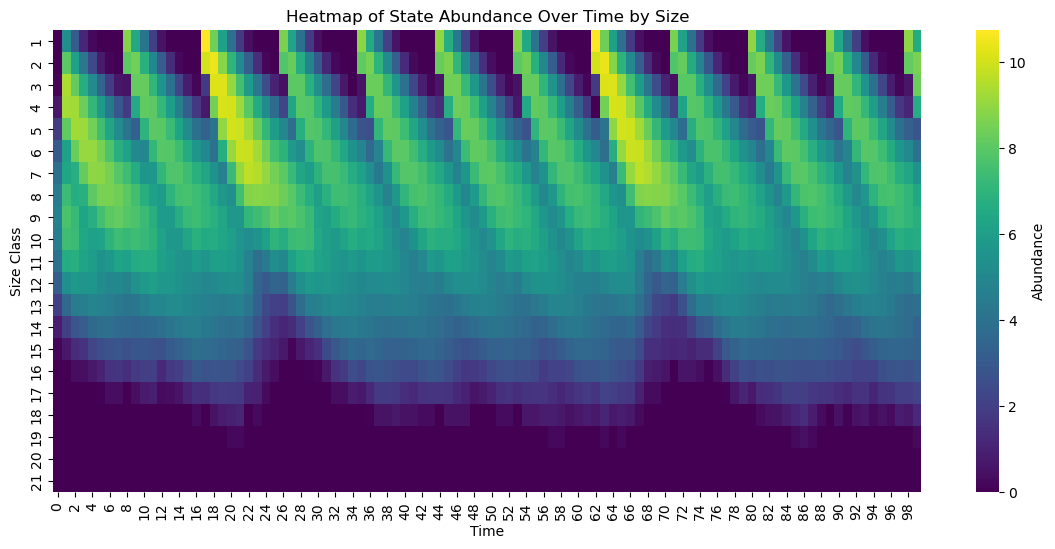

In [174]:
fig = state_heatmap(tqcDataDF, rep=0, use_log=True)

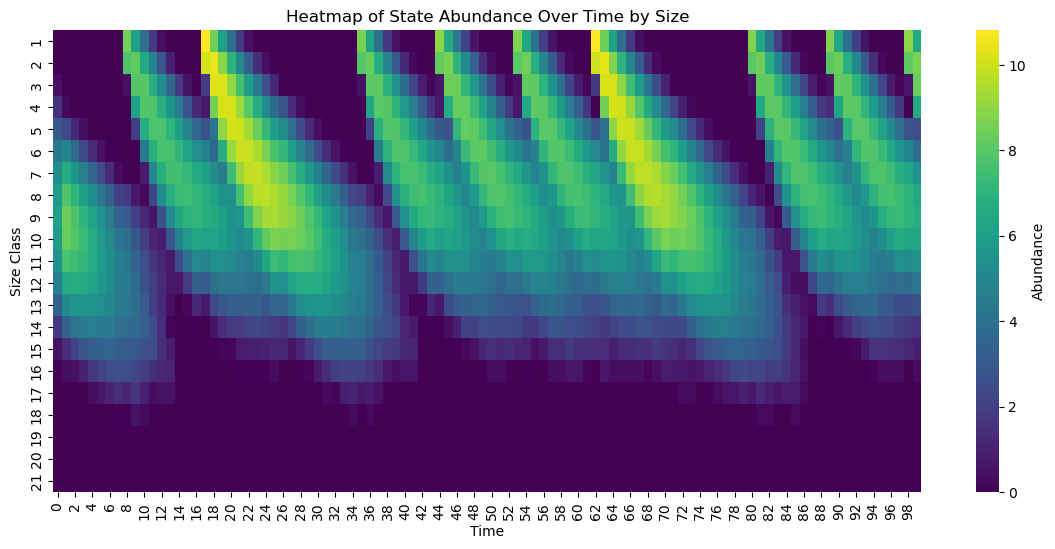

In [157]:
fig = state_heatmap(optimalDataDF, rep=0, use_log=True)

In [175]:
df = tqcDataDF
df[df['rep']==0].loc[:, ['t', 'crab_pop']].iloc[29, :]

t                                                          29
crab_pop    [4.861763060497872 119.29862592149452 923.2237...
Name: 29, dtype: object

In [176]:
df = noInterventionDataDF
df[df['rep']==0].loc[:, ['t', 'crab_pop']].iloc[29, :]

t                                                          29
crab_pop    [1.3453621795930737e-18 1.1291399117598806e-11...
Name: 29, dtype: object

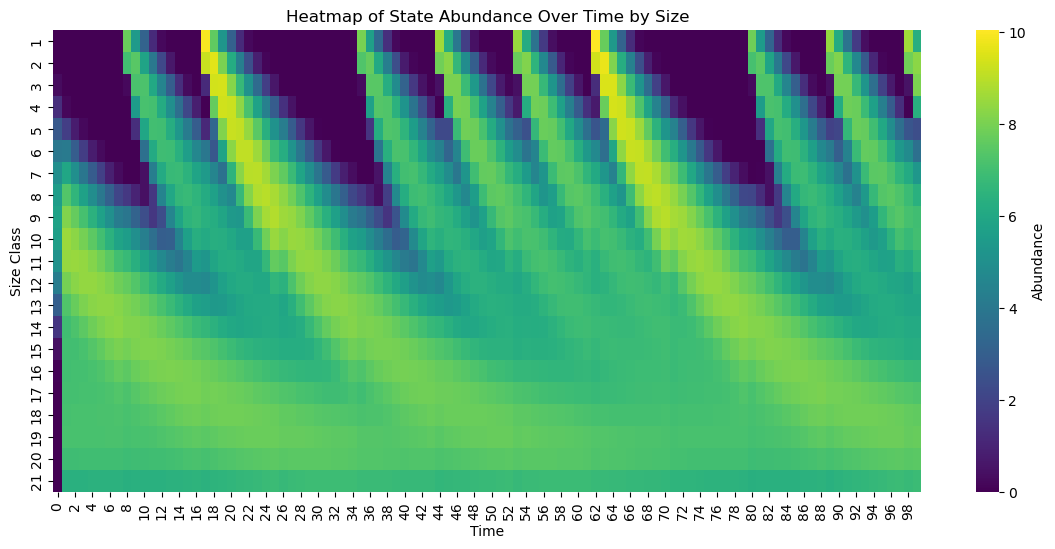

In [171]:
fig = state_heatmap(noInterventionDataDF, rep=0, use_log=True)

In [23]:
fig.savefig("my_seaborn.png")

,t,crab_pop,state
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
95,95,"[0.24862060726209603, 11.388402996746267, 186....","[0.0, 2.432595556631794, 5.2276587861227615, 7..."
96,96,"[0.007933843533255762, 1.4769453629121765, 34....","[0.0, 0.38997601093014034, 3.5531755063534605,..."
97,97,"[0.0007246775935896524, 0.15287909548336048, 5...","[0.0, 0.0, 1.7905935791231944, 4.4643703634148..."
98,98,"[9.743814131096469e-07, 0.005309801047472413, ...","[0.0, 0.0, 0.0, 2.9247044335592483, 5.23514127..."


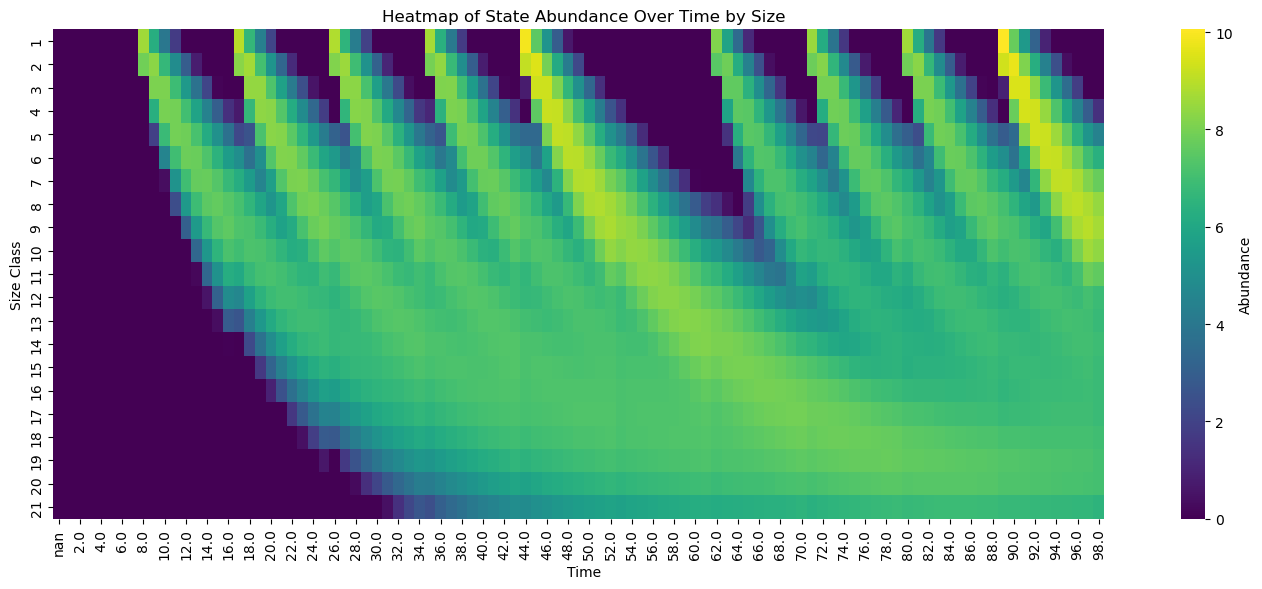

In [115]:
state_heatmap(noInterventionDataDF, rep=1)